# Stroke Prediction Model (Binary Classification)

## A comparative analysis of machine learning classifiers for stroke prediction

In [68]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

#from imblearn.over_sampling import SMOTE
#from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, RobustScaler
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import RandomOverSampler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier, NearestCentroid
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

In [69]:
import platform
print(f"Python version: {platform.python_version()}")
print(f"numpy version: {np.__version__}")
print(f"panda version: {pd.__version__}")
print(f"seaborn version: {sns.__version__}")
import matplotlib
print(f"matplotlib version: {matplotlib.__version__}")
import statsmodels
print(f"statsmodel version: {statsmodels.__version__}")
import scipy
print(f"scipy version: {scipy.__version__}")
import sklearn 
print(f"sklearn version: {sklearn. __version__}")

Python version: 3.10.14
numpy version: 1.23.5
panda version: 2.1.4
seaborn version: 0.13.2
matplotlib version: 3.7.5
statsmodel version: 0.14.1
scipy version: 1.11.4
sklearn version: 1.4.1.post1


In [70]:
# Function to remove outliers using IQR method
def remove_outliers(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df

# Importing the dataset

In [72]:
# https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset

In [73]:
data = pd.read_csv('.\Documents\healthcare-dataset-stroke-data.csv')

In [74]:
data.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [75]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [76]:
data.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


### Check imbalance target

In [78]:
#count occurrence of each value in 'stroke' column
counts = data['stroke'].value_counts()

#count occurrence of each value in 'stroke' column as percentage of total 
percs = data['stroke'].value_counts(normalize=True)

#concatenate results into one DataFrame
count_active= pd.concat([counts,percs], axis=1, keys=['count', 'percentage'])
#count_active['percentage'] = count_active['percentage'].transform(lambda x: '{:,.2%}'.format(x))
count_active['percentage'] = count_active['percentage'].apply(lambda x: f'{x * 100:.2f}%')

In [79]:
count_active

,count,percentage
stroke,,
0,4861,95.13%
1,249,4.87%


### Check missing values

In [81]:
data.isnull().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [82]:
# Handle missing values in BMI
imputer = SimpleImputer(strategy='mean')
data['bmi'] = imputer.fit_transform(data[['bmi']])
data.isnull().sum()

id                   0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

In [83]:
# Remove outliers from numerical columns
numerical_columns = ['age', 'avg_glucose_level', 'bmi']
data = remove_outliers(data, numerical_columns)

## Visualize

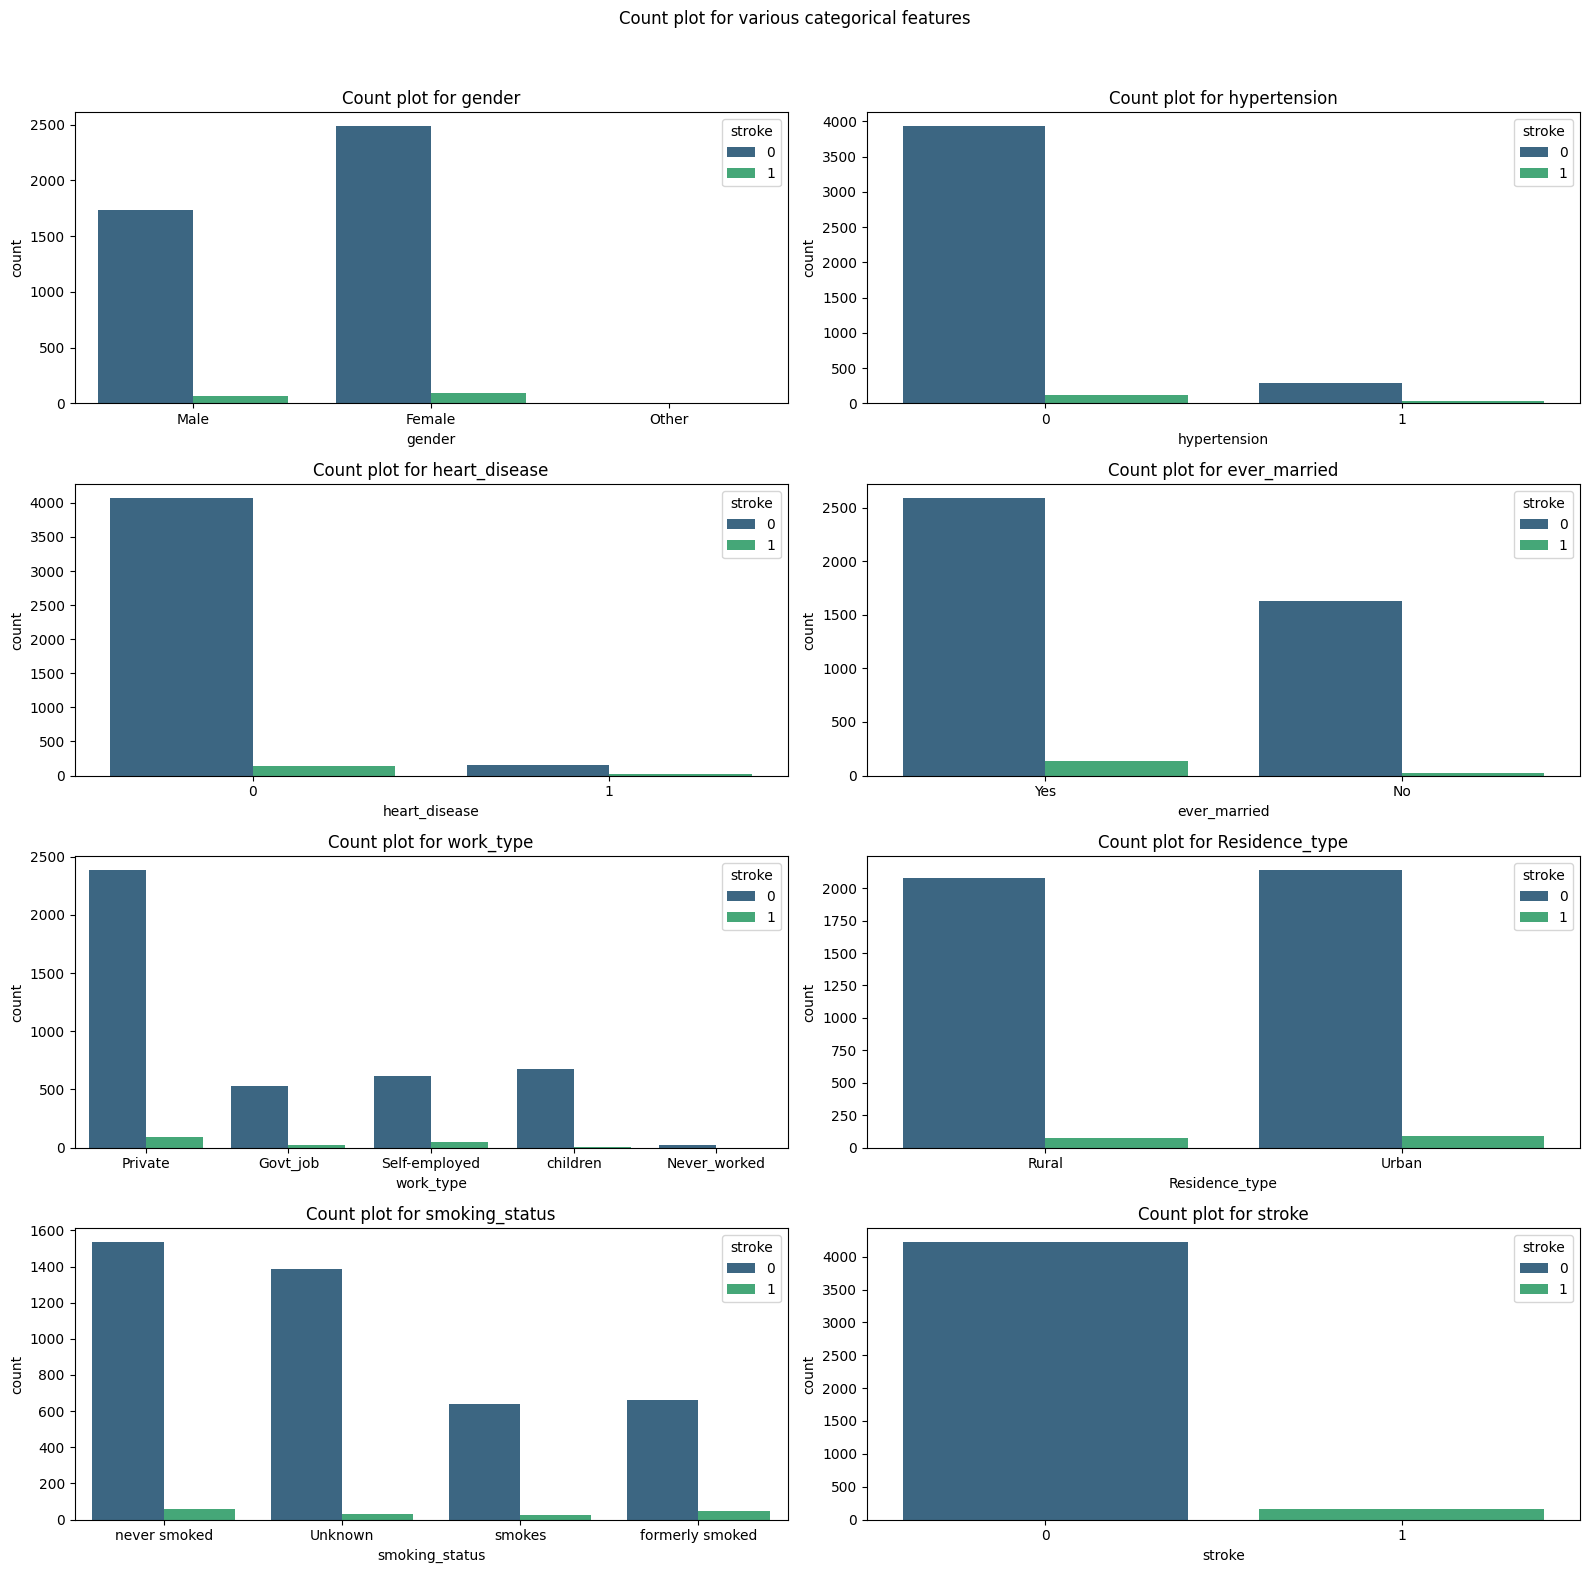

In [85]:
# List of categorical features
categorical_features = [
    'gender', 'hypertension', 'heart_disease', 'ever_married', 
    'work_type', 'Residence_type', 'smoking_status', 'stroke'
]

# Define a color palette (Seaborn palettes or custom colors can be used)
custom_palette = "viridis"

# Create subplots
fig, axes = plt.subplots(4, 2, figsize=(16, 16))
fig.suptitle("Count plot for various categorical features")

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Use a for loop to create count plots
for ax, feature in zip(axes, categorical_features):
    sns.countplot(ax=ax, data=data, x=feature, hue =data['stroke'], palette=custom_palette)
    ax.set_title(f'Count plot for {feature}')

# Adjust layout and display the plot
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Leave space for the title
plt.show()

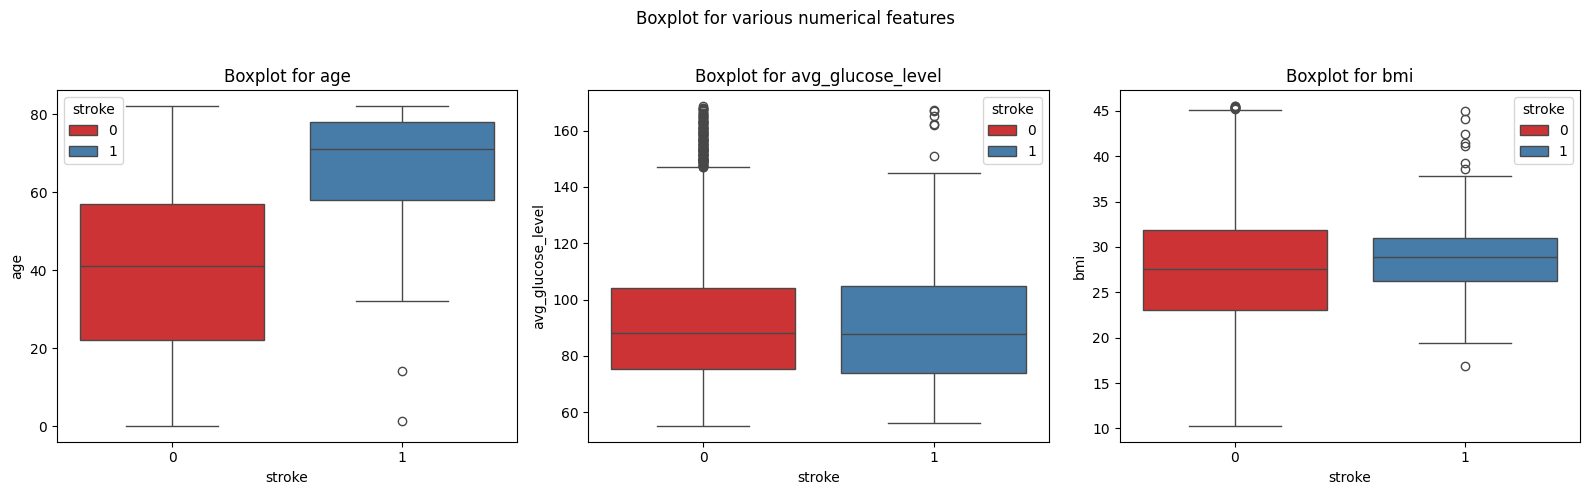

In [86]:
numeric_features = ['age', 'avg_glucose_level', 'bmi']

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
fig.suptitle("Boxplot for various numerical features")
axs = axes.flatten()

# iterate through each column in df_num and plot
for ax, feature in zip(axes, numeric_features):
    sns.boxplot(ax=ax, x="stroke", data=data, y=feature, hue="stroke", palette= 'Set1')
    ax.set_title(f'Boxplot for {feature}')

# Adjust layout and display the plot
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Leave space for the title
plt.show()

In [87]:
# Encode categorical variables
label_encoders = {}
for column in ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']:
    le = LabelEncoder()
    data[column] = le.fit_transform(data[column])
    label_encoders[column] = le

In [88]:
data.tail()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
5105,18234,0,80.0,1,0,1,2,1,83.75,28.893237,2,0
5106,44873,0,81.0,0,0,1,3,1,125.20,40.000000,2,0
5107,19723,0,35.0,0,0,1,3,0,82.99,30.600000,2,0
5108,37544,1,51.0,0,0,1,2,0,166.29,25.600000,1,0
5109,44679,0,44.0,0,0,1,0,1,85.28,26.200000,0,0


In [89]:
# Split the data into features and target
X = data.drop(['id','stroke'], axis=1)
y = data['stroke']

# Split the Data into Training and Testing Sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [90]:
len(X_train), len(X_test), len(y_train), len(y_test)

(3506, 877, 3506, 877)

In [91]:
# Handle Imbalanced Data with Random Oversampling
ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

In [92]:
len(X_train_resampled), len(y_train_resampled)

(6756, 6756)

In [93]:
# Define Classifiers and Hyperparameter Grids
classifiers = {
    'SVM': SVC(),
    'RandomForest': RandomForestClassifier(),
    'KNN': KNeighborsClassifier(),
    'DecisionTree': DecisionTreeClassifier(),
    'NaiveBayes': GaussianNB(),
    'LogisticRegression': LogisticRegression(),
    'AdaBoost': AdaBoostClassifier(),
    'GradientBoosting': GradientBoostingClassifier(),
    'MLP': MLPClassifier(),
    'NearestCluster': NearestCentroid(),  # Using NearestCentroid instead of KMeans
    'Bagging': BaggingClassifier(),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

param_grids = {
    'SVM': {'classifier__kernel': ['linear', 'rbf'], 'classifier__C': [0.1, 1, 10], 'classifier__gamma': ['scale', 'auto']},
    'RandomForest': {'n_estimators': [100, 200], 'max_depth': [None, 5, 10], 'min_samples_split': [2, 5, 10], 'criterion': ['gini', 'entropy']},
    'KNN': {'classifier__n_neighbors': [3, 5, 7], 'classifier__weights': ['uniform', 'distance'], 'classifier__metric': ['euclidean', 'manhattan']},
    'DecisionTree': {'max_depth': [None, 5, 10], 'min_samples_split': [2, 5, 10], 'criterion': ['gini', 'entropy']},
    'NaiveBayes': {'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]},
    'LogisticRegression': {'classifier__C': [0.1, 1, 10], 'classifier__penalty': ['l1', 'l2'], 'classifier__solver': ['liblinear']},
    'AdaBoost': {'n_estimators': [50, 100], 'learning_rate': [0.01, 0.1, 1]},
    'GradientBoosting': {'n_estimators': [50, 100], 'learning_rate': [0.01, 0.1, 1], 'max_depth': [3, 5, 7]},
    'MLP': {'classifier__hidden_layer_sizes': [(50,), (100,), (50, 50)], 'classifier__activation': ['relu', 'tanh'], 'classifier__solver': ['adam'], 'classifier__alpha': [0.0001, 0.001]},
    'NearestCluster': {'classifier__metric': ['euclidean', 'manhattan', 'cosine'], 'classifier__shrink_threshold': [None, 0.1, 0.5, 1.0]},
    'Bagging': {'n_estimators': [10, 50, 100, 200], 'max_samples': [0.5, 0.75, 1.0], 'bootstrap': [True, False]},
    'XGBoost': {'n_estimators': [50, 100], 'learning_rate': [0.01, 0.1, 0.2], 'max_depth': [3, 5, 7]}
}

In [94]:
# Hyperparameter Tuning with GridSearchCV
best_models = {}
for name, classifier in classifiers.items(): 
    if name in ['SVM', 'KNN', 'LogisticRegression', 'MLP', 'NearestCluster']:  # Classifiers that require feature scaling
        pipeline = Pipeline([('scaler', RobustScaler()), ('classifier', classifier)])
    else:
        pipeline = classifier
    
    if param_grids[name]:
        grid_search = GridSearchCV(pipeline, param_grids[name], cv=10, scoring='accuracy', n_jobs=-1)
        grid_search.fit(X_train_resampled, y_train_resampled)
        best_models[name] = grid_search.best_estimator_
    else:
        pipeline.fit(X_train_resampled, y_train_resampled)
        best_models[name] = pipeline

In [95]:
# 10-Fold Cross Validation
print("10-Fold Cross Validation Results:")
cv_scores = {}
for name, model in best_models.items():
    scores = cross_val_score(model, X_train_resampled, y_train_resampled, cv=10, scoring='accuracy')
    cv_scores[name] = np.mean(scores)
    print(f"{name} CV Accuracy: {cv_scores[name]:.4f}")

10-Fold Cross Validation Results:
SVM CV Accuracy: 0.9100
RandomForest CV Accuracy: 0.9964
KNN CV Accuracy: 0.9685
DecisionTree CV Accuracy: 0.9861
NaiveBayes CV Accuracy: 0.7411
LogisticRegression CV Accuracy: 0.7726
AdaBoost CV Accuracy: 0.8435
GradientBoosting CV Accuracy: 0.9944
MLP CV Accuracy: 0.9744
NearestCluster CV Accuracy: 0.7645
Bagging CV Accuracy: 0.9899
XGBoost CV Accuracy: 0.9867


In [96]:
# Evaluate on Test Set with Error Rate
print("\nTest Set Evaluation Results:")
for name, model in best_models.items():
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    TN, FP, FN, TP = cm.ravel()
    error_rate = (FP + FN) / (TP + TN + FP + FN)
    print(f"\n{name} Test Accuracy: {accuracy:.4f}")
    print(f"{name} Error Rate: {error_rate:.4f}")
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))


Test Set Evaluation Results:

SVM Test Accuracy: 0.8050
SVM Error Rate: 0.1950
[[694 147]
 [ 24  12]]
              precision    recall  f1-score   support

           0       0.97      0.83      0.89       841
           1       0.08      0.33      0.12        36

    accuracy                           0.81       877
   macro avg       0.52      0.58      0.51       877
weighted avg       0.93      0.81      0.86       877


RandomForest Test Accuracy: 0.9521
RandomForest Error Rate: 0.0479
[[832   9]
 [ 33   3]]
              precision    recall  f1-score   support

           0       0.96      0.99      0.98       841
           1       0.25      0.08      0.12        36

    accuracy                           0.95       877
   macro avg       0.61      0.54      0.55       877
weighted avg       0.93      0.95      0.94       877


KNN Test Accuracy: 0.9111
KNN Error Rate: 0.0889
[[792  49]
 [ 29   7]]
              precision    recall  f1-score   support

           0       0.96 

In [97]:
# Voting Classifier with Error Rate
voting_clf = VotingClassifier(estimators=[
    ('svm', best_models['SVM']),
    ('rf', best_models['RandomForest']),
    ('lr', best_models['LogisticRegression'])
], voting='hard')

voting_clf.fit(X_train_resampled, y_train_resampled)
y_pred_voting = voting_clf.predict(X_test)
accuracy_voting = accuracy_score(y_test, y_pred_voting)
cm_voting = confusion_matrix(y_test, y_pred_voting)
TN, FP, FN, TP = cm_voting.ravel()
error_rate_voting = (FP + FN) / (TP + TN + FP + FN)
print(f"\nVoting Classifier Test Accuracy: {accuracy_voting:.4f}")
print(f"Voting Classifier Error Rate: {error_rate_voting:.4f}")
print(classification_report(y_test, y_pred_voting))


Voting Classifier Test Accuracy: 0.8472
Voting Classifier Error Rate: 0.1528
              precision    recall  f1-score   support

           0       0.97      0.87      0.92       841
           1       0.10      0.33      0.15        36

    accuracy                           0.85       877
   macro avg       0.53      0.60      0.53       877
weighted avg       0.93      0.85      0.88       877



In [98]:
# Evaluate on Test Set and Collect Metrics
metrics_list = []
for name, model in best_models.items():
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else np.nan
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    TN, FP, FN, TP = cm.ravel()
    error_rate = (FP + FN) / (TP + TN + FP + FN)
    
    metrics_list.append({
        'Model': name,
        'Accuracy': accuracy,
        'K-Fold Mean Accuracy': cv_scores[name],
        'ROC_AUC': roc_auc,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'Error Rate': error_rate
    })

# Create DataFrame for Metrics
metrics_df = pd.DataFrame(metrics_list)
print("\nModel Evaluation Metrics Consolidated in DataFrame:\n")
print(metrics_df)

# Optional: Save to CSV
#metrics_df.to_csv('model_evaluation_metrics.csv', index=False)


Model Evaluation Metrics Consolidated in DataFrame:

                 Model  Accuracy  K-Fold Mean Accuracy   ROC_AUC  Precision  \
0                  SVM  0.805017              0.910009       NaN   0.075472   
1         RandomForest  0.952109              0.996446  0.834440   0.250000   
2                  KNN  0.911060              0.968472  0.581352   0.125000   
3         DecisionTree  0.927024              0.986086  0.536531   0.111111   
4           NaiveBayes  0.703535              0.741120  0.813020   0.097122   
5   LogisticRegression  0.720639              0.772643  0.823259   0.102662   
6             AdaBoost  0.759407              0.843546  0.779413   0.096774   
7     GradientBoosting  0.948689              0.994376  0.648236   0.235294   
8                  MLP  0.917902              0.974394  0.663430   0.140000   
9       NearestCluster  0.615735              0.764507       NaN   0.087671   
10             Bagging  0.942987              0.989934  0.769669   0.230769  

In [99]:
metrics_df

,Model,Accuracy,K-Fold Mean Accuracy,ROC_AUC,Precision,Recall,F1 Score,Error Rate
0,SVM,0.805017,0.910009,NaN,0.075472,0.333333,0.123077,0.194983
1,RandomForest,0.952109,0.996446,0.834440,0.250000,0.083333,0.125000,0.047891
2,KNN,0.911060,0.968472,0.581352,0.125000,0.194444,0.152174,0.088940
3,DecisionTree,0.927024,0.986086,0.536531,0.111111,0.111111,0.111111,0.072976
4,NaiveBayes,0.703535,0.741120,0.813020,0.097122,0.750000,0.171975,0.296465
5,LogisticRegression,0.720639,0.772643,0.823259,0.102662,0.750000,0.180602,0.279361
6,AdaBoost,0.759407,0.843546,0.779413,0.096774,0.583333,0.166008,0.240593
7,GradientBoosting,0.948689,0.994376,0.648236,0.235294,0.111111,0.150943,0.051311
8,MLP,0.917902,0.974394,0.663430,0.140000,0.194444,0.162791,0.082098
9,NearestCluster,0.615735,0.764507,NaN,0.087671,0.888889,0.159601,0.384265


Optimal hyperparameter combination:  {'bootstrap': True, 'max_samples': 0.75, 'n_estimators': 10}
feature importances:  {'gender': 0.02386782513794413, 'age': 0.4826687481687415, 'hypertension': 0.009058691769409936, 'heart_disease': 0.003281244870238082, 'ever_married': 0.012540936275437217, 'work_type': 0.01943658620390037, 'Residence_type': 0.021365973517753333, 'avg_glucose_level': 0.17461910627766863, 'bmi': 0.21485522795374284, 'smoking_status': 0.03830565982516388}


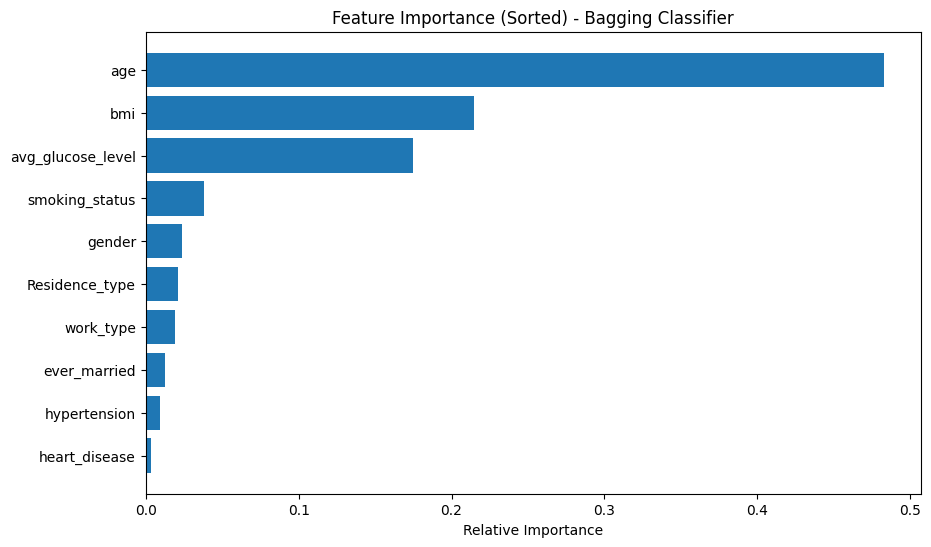

In [100]:
# Hyperparameter tuning (assumed Bagging is best)
bagging_clf = BaggingClassifier()
param_grid = {
    'n_estimators': [10, 50, 100, 200], 
    'max_samples': [0.5, 0.75, 1.0], 
    'bootstrap': [True, False]
}
grid_search = GridSearchCV(bagging_clf, param_grid, cv=10, scoring='accuracy', n_jobs=-1)
model_gs = grid_search.fit(X_train_resampled, y_train_resampled)
# best paramaters selected by gridsearch
print('Optimal hyperparameter combination: ',model_gs.best_params_)

best_bagging = grid_search.best_estimator_

# Get feature importances from the best estimator
# code from https://medium.com/@vikashsinghy2k/complete-guide-to-bagging-classifier-in-python-ce9593af6fdd
importances = np.mean([tree.feature_importances_ for tree in best_bagging.estimators_], axis=0)
features = X.columns


output = {fn:fi for fn,fi in zip(features,importances)}
print('feature importances: ', output)

# Sort features by importance in descending order
indices = np.argsort(importances)[::-1]

# Plot the feature importances in descending order
plt.figure(figsize=(10,6))
plt.title("Feature Importance (Sorted) - Bagging Classifier")
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.gca().invert_yaxis()  # To have the most important feature at the top
plt.show()



Optimal hyperparameter combination:  {'criterion': 'gini', 'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
             Feature  Importance
1                age    0.410756
8                bmi    0.192073
7  avg_glucose_level    0.177514
9     smoking_status    0.054527
5          work_type    0.049879
4       ever_married    0.038181
2       hypertension    0.022594
0             gender    0.020742
6     Residence_type    0.020545
3      heart_disease    0.013190


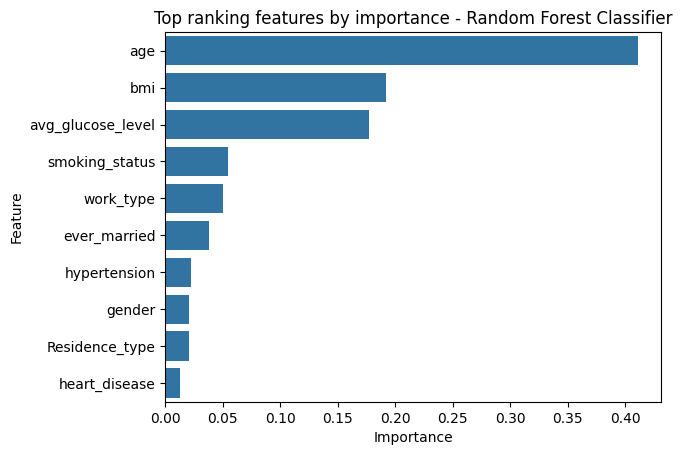

In [140]:
# Hyperparameter tuning (assumed Random Forest is best)
rf = RandomForestClassifier()
param_grid = {
    'n_estimators': [100, 200], 
    'max_depth': [None, 5, 10], 
    'min_samples_split': [2, 5, 10], 
    'criterion': ['gini', 'entropy']
}
grid_search = GridSearchCV(rf, param_grid, cv=10, scoring='accuracy', n_jobs=-1)
model_rf = grid_search.fit(X_train_resampled, y_train_resampled)
# best paramaters selected by gridsearch
print('Optimal hyperparameter combination: ',model_rf.best_params_)

best_rf = grid_search.best_estimator_
feature_importances = best_rf.feature_importances_

feature_names = X.columns
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

print(importance_df)

x = importance_df['Importance']
y = importance_df['Feature']
sns.barplot(x = x, y = y).set_title('Top ranking features by importance - Random Forest Classifier');

# Save the plot as a JPG file
plt.savefig('rf_fi.jpg')

# Optionally, display the plot
plt.show()

https://github.com/Nizarassad/Stroke-prediction/blob/master/Stroke_modeling.ipynb
https://griddb.net/en/blog/stroke-prediction-using-machine-learning-python-and-griddb/
https://github.com/nurahmadi/Stroke-prediction-with-ML/blob/master/Stroke%20Prediction%20and%20Analysis%20-%20Notebook.ipynb
https://www.kaggle.com/code/nikunjmalpani/stroke-prediction-step-by-step-guide
https://github.com/JoeKomo/Machine-Learning/blob/main/ML_ICA_code.ipynb
https://github.com/adrianlardies/MachineLearning-project/blob/main/notebook/machinelearning.ipynb
https://github.com/Chando0185/Brain_Stroke_Prediction/blob/main/Stroke%20Prediction%20Using%20Python.ipynb

https://medium.com/@adrianlardies/machine-learning-pipeline-for-imbalanced-data-stroke-prediction-e3163e9cc1a8
https://medium.com/@JoeKomo/machine-learning-approaches-for-stroke-prediction-a-performance-evaluation-3a1d008dab68
https://medium.com/@jeffdm88/machine-learning-for-stroke-prediction-ab886a1f7828
https://medium.com/geekculture/stroke-prediction-d26c15f9d1
https://medium.com/nerd-for-tech/stroke-prediction-imbalanced-data-b6c406a81b8a